In [1]:
import sys
sys.path.append('../Scripts')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from capstone_functions import *

# Results : 
based on comparing scores on 0.3 holdout set.
Algorithms:
K-medoids performs better on train and test set in case with low levels of outlier filtering.
Outlier Filtering
filter between 0.1 percent and 1 percent (.6 to .7) are the best 
CLusters:
saturday 2 is bad
off_peak_split and holiday simple / holiday_6 are all good
### 

In [4]:
def prepare_data_for_scoring(
                input_path='../Inputs/',
                crash_source_csv='Train',
                outlier_filter=0,
                holdout_strategy='random', 
                holdout_test_size=0.3,
                tw_cluster_strategy='saturday_2', 
                verbose=0,
                placement_method='k_means'
                ):
    crash_df = create_crash_df(train_file = input_path+crash_source_csv+'.csv')
    # create individual date and time features from date column
    crash_df = create_temporal_features(crash_df)
    # split data into train and test sets
    train_df, test_df = split_accident_df(data=crash_df, strategy=holdout_strategy,
                                          test_size=holdout_test_size)
    # remove outliers from test set based on lat and lon
    train_df = outlier_removal(train_df, filter=outlier_filter)
    # apply time window cluster labels to df based on strategy specified
    train_df = create_cluster_feature(train_df, strategy=tw_cluster_strategy, verbose=verbose)
    # Run clustering model to get placement set centroids for each TW cluster
    test_df_with_clusters = create_cluster_feature(test_df, strategy=tw_cluster_strategy, verbose=0)
    centroids_dict = create_cluster_centroids(train_df, test_df=test_df_with_clusters, verbose=verbose, method=placement_method)
    train_placements_df = centroid_to_submission(centroids_dict, date_start='2018-01-01', date_end='2019-12-31',
                                                 tw_cluster_strategy=tw_cluster_strategy)
    test_score = score(train_placements_df, test_df, test_start_date='2018-01-01',
                       test_end_date='2019-12-31')
    #train_score = score(train_placements_df,train_df, test_start_date='2018-01-01',
    #                   test_end_date='2019-12-31')
    return (test_score/ max(test_df.shape[0],1)) #, (train_score/train_df.shape[0])

In [5]:
from tqdm import tqdm, trange
import numpy as np

In [6]:
def get_scores():
    score_list = []
    for model in tqdm((['k_medoids'])):
        for cluster_strat in tqdm((['saturday_2', 'holiday_simple', 'off_peak_split', 'holiday_6'])):
            for out_filter in trange(10, 100, 10):
                # test_score, train_score = prepare_data_for_scoring(
                test_score = prepare_data_for_scoring(
                                                                input_path='../Inputs/',
                                                                crash_source_csv='Train',
                                                                outlier_filter=out_filter/10000,
                                                                holdout_strategy='random', 
                                                                holdout_test_size=0.3,
                                                                tw_cluster_strategy=cluster_strat, 
                                                                verbose=0,
                                                                placement_method=model

                )
                score_list.append([model, cluster_strat, out_filter/100, test_score]) #, train_score])
    return score_list

In [7]:
score_list =  get_scores()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:03<00:26,  3.37s/it]

 22%|██▏       | 2/9 [00:06<00:23,  3.35s/it]

 33%|███▎      | 3/9 [00:09<00:19,  3.33s/it]

 44%|████▍     | 4/9 [00:13<00:16,  3.38s/it]

 56%|█████▌    | 5/9 [00:17<00:13,  3.43s/it]

 67%|██████▋   | 6/9 [00:20<00:10,  3.50s/it]

 78%|███████▊  | 7/9 [00:24<00:07,  3.64s/it]

 89%|████████▉ | 8/9 [00:28<00:03,  3.58s/it]

100%|██████████| 9/9 [00:31<00:00,  3.49s/it]

 25%|██▌       | 1/4 [00:31<01:34, 31.38s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:03<00:26,  3.35s/it]

 22%|██▏       | 2/9 [00:07<00:24,  3.44s/it]

 33%|███▎      | 3/9 [00:10<00:20,  3.41s/it]

 44%|████▍     | 4/9 [00:13<00:16,  3.37s/it]

 56%|█████▌    | 5/9 [00:17<00:13,  3.42s/it]

 67%|██████▋   | 6/9 [00:20<00:10,  3.39s/it]

 78%|███████▊  | 7/9 [00:23<00:06,  3.34s/it]

 89%|████████▉ | 8/9 [00:27<00:03,  3.48s/it]

100%|██████████| 9/9 [00:31<00:00,  3

In [12]:
k_compare = pd.DataFrame(score_list, columns=['model', 'cluster_strat', 'filter', 'test_score']) #, 'train_score'])

In [13]:
k_compare.round(3)
k_compare.sort_values(by='test_score')


,model,cluster_strat,filter,test_score
24,k_medoids,off_peak_split,0.7,0.051071
23,k_medoids,off_peak_split,0.6,0.051335
15,k_medoids,holiday_simple,0.7,0.051392
33,k_medoids,holiday_6,0.7,0.051435
19,k_medoids,off_peak_split,0.2,0.051561
32,k_medoids,holiday_6,0.6,0.051611
14,k_medoids,holiday_simple,0.6,0.051656
5,k_medoids,saturday_2,0.6,0.051687
34,k_medoids,holiday_6,0.8,0.052121
17,k_medoids,holiday_simple,0.9,0.052469


In [10]:
'''for i, strat in enumerate(k_compare['cluster_strat'].unique()):
    print(strat)
    df = k_compare.query('cluster_strat == @strat')
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(16, 16))
    chart = sns.pointplot(ax=ax, data=df, x="filter", y='train_score', hue='model');
    chart = sns.pointplot(ax=ax, data=df, x="filter", y='test_score', hue='model');
'''

'for i, strat in enumerate(k_compare[\'cluster_strat\'].unique()):\n    print(strat)\n    df = k_compare.query(\'cluster_strat == @strat\')\n    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(16, 16))\n    chart = sns.pointplot(ax=ax, data=df, x="filter", y=\'train_score\', hue=\'model\');\n    chart = sns.pointplot(ax=ax, data=df, x="filter", y=\'test_score\', hue=\'model\');\n'

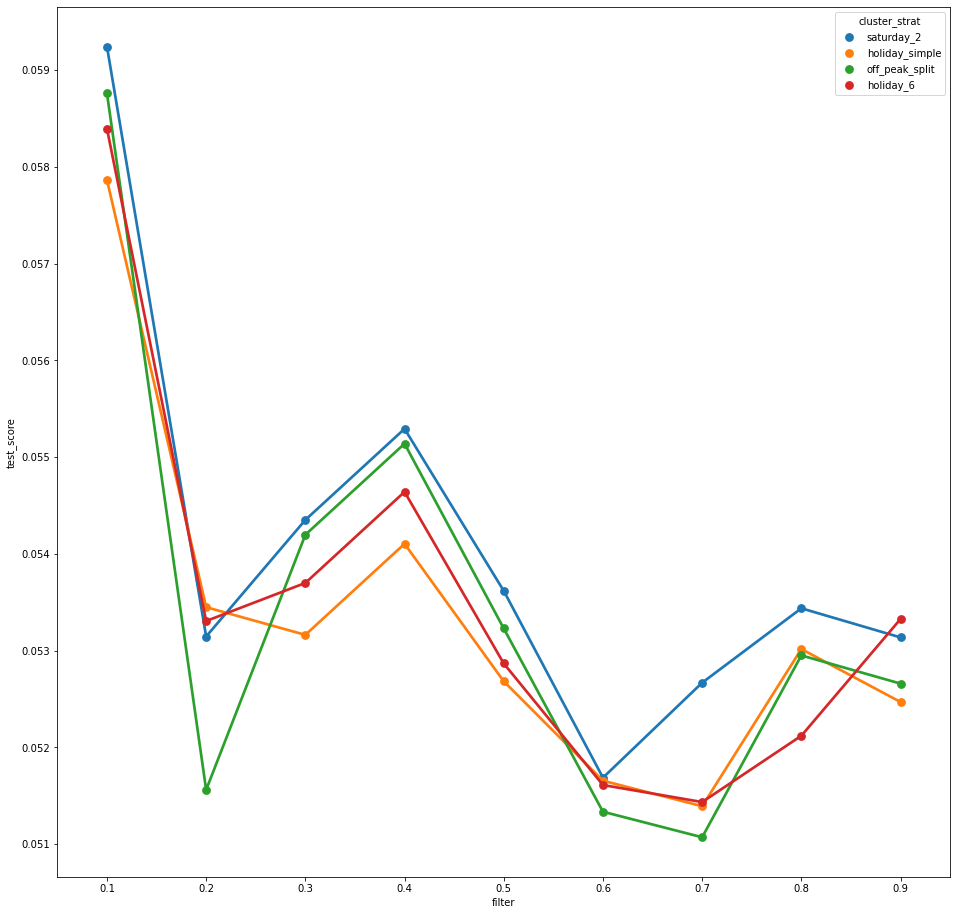

In [14]:

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(16, 16))
#chart = sns.pointplot(ax=ax, data=k_compare, x="filter", y='train_score', hue='cluster_strat');
chart = sns.pointplot(ax=ax, data=k_compare, x="filter", y='test_score', hue='cluster_strat');
